## Required Libraries

In [3]:
import pandas as pd
import numpy as np


## Data Preprocessing

In [5]:
# Read only the first two columns
#df = pd.read_csv("Waste_3_6.csv", usecols=[0, 1])

df = pd.read_csv("Waste_3_6_July_Nov.csv", usecols=[0, 1])  ### new data set

# Rename columns
df.columns = ["Datetime", "Flow[cfs]"]

# Convert to datetime (auto-detects all formats)
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")

# Convert flow values to numeric
df["Flow[cfs]"] = pd.to_numeric(df["Flow[cfs]"], errors="coerce")

# Drop invalid rows and set datetime index
df = df.dropna(subset=["Datetime"]).set_index("Datetime")

# Count how many have missing flow values
missing_points = df["Flow[cfs]"].isna().sum()

# Display first few rows
print(df.head())
print("Missing point",missing_points)



                     Flow[cfs]
Datetime                      
2025-07-18 17:08:00    0.45576
2025-07-18 17:18:00    0.47959
2025-07-18 17:28:00    0.47959
2025-07-18 17:38:00    0.44781
2025-07-18 17:48:00    0.40810
Missing point 0


### Resample into 10 min flow 

In [7]:
# Resample to a strict 10-minute grid and compute the mean per bin
flow_10min = df.resample("10min").mean()

### detecting and handliing outliers if any

In [9]:
# Compute quartiles
Q1 = flow_10min["Flow[cfs]"].quantile(0.25)
Q3 = flow_10min["Flow[cfs]"].quantile(0.75)
IQR = Q3 - Q1

# Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = flow_10min[
    (flow_10min["Flow[cfs]"] < lower_bound) | 
    (flow_10min["Flow[cfs]"] > upper_bound)
]

print(f"Total outliers detected: {len(outliers)}")
print(f"Lower bound: {lower_bound:.3f}, Upper bound: {upper_bound:.3f}")

Total outliers detected: 0
Lower bound: 0.131, Upper bound: 1.018


In [11]:
flow_10min.loc[
    (flow_10min["Flow[cfs]"] < lower_bound) | 
    (flow_10min["Flow[cfs]"] > upper_bound), 
    "Flow[cfs]"
] = None

### Interpolate missing and outlier gaps (time-based)

In [19]:
# fill gaps smoothly if there are any using time-based interpolation
flow_10min = flow_10min.interpolate(method="time")

# Display first few rows
print(flow_10min.head())

                     Flow[cfs]
Datetime                      
2025-07-18 17:00:00    0.45576
2025-07-18 17:10:00    0.47959
2025-07-18 17:20:00    0.47959
2025-07-18 17:30:00    0.44781
2025-07-18 17:40:00    0.40810


# ML Models

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error
import numpy as np


### Build sliding windows for multi-output targets

In [50]:
values = flow_10min["Flow[cfs]"].values
n_lags = 36         # past 6 hours
n_outputs = 36      # predict next 6 hours (10-min steps)

X, y = [], []
for i in range(n_lags, len(values) - n_outputs):
    X.append(values[i - n_lags:i])        # input sequence
    y.append(values[i:i + n_outputs])     # next 36 values

X = np.array(X)
y = np.array(y)

print(f"Samples: {X.shape[0]},  Input shape: {X.shape[1]},  Output shape: {y.shape[1]}")


Samples: 10552,  Input shape: 36,  Output shape: 36


### Chronological train/validation/test split

In [53]:
train_size = int(0.7 * len(X))
val_size   = int(0.15 * len(X))

X_train, X_val, X_test = (
    X[:train_size],
    X[train_size:train_size + val_size],
    X[train_size + val_size:]
)
y_train, y_val, y_test = (
    y[:train_size],
    y[train_size:train_size + val_size],
    y[train_size + val_size:]
)

print(X_train.shape, X_val.shape, X_test.shape)


(7386, 36) (1582, 36) (1584, 36)


### Hyperparameter Tuning

In [55]:
# Define the base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define the hyperparameter search space
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Define RMSE scorer (since we want to minimize RMSE)
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Randomized search with cross-validation (5 random folds)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=25,             # number of random combinations to test
    scoring=rmse_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
rf_random.fit(X_train, y_train)

# Show best parameters and score
print("Best Parameters:")
print(rf_random.best_params_)

print(f"Best RMSE (CV): {-rf_random.best_score_:.4f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best RMSE (CV): 0.0858


### Re-train with the best parameters

In [59]:
best_params = rf_random.best_params_

rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, n_jobs=-1,
                      random_state=42)

### Evaluate on validation and test sets

In [79]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

y_val_pred = rf_best.predict(X_val)
y_test_pred = rf_best.predict(X_test)

def evaluate_multistep(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return mae, rmse

mae_val, rmse_val = evaluate_multistep(y_val, y_val_pred)
mae_test, rmse_test = evaluate_multistep(y_test, y_test_pred)

print(f"Validation → MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}")
print(f"Test → MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}")


Validation → MAE: 0.0726, RMSE: 0.0908
Test → MAE: 0.0916, RMSE: 0.1119


### Feature importance (lag contribution)

In [86]:
# import matplotlib.pyplot as plt
# import pandas as pd

# feature_importance = pd.Series(rf_best.feature_importances_, 
#                                index=[f"lag_{i}" for i in range(36, 0, -1)])

# feature_importance.sort_values(ascending=False).head(15).plot(kind='bar', figsize=(10,4))
# plt.title("Top Feature Importances (RF)")
# plt.ylabel("Importance")
# plt.show()


### Build timestamps and plot observed vs. predicted

                     Observed  Predicted
2025-09-19 05:50:00   0.42396   0.439779
2025-09-19 06:00:00   0.40810   0.438727
2025-09-19 06:10:00   0.39228   0.442098
2025-09-19 06:20:00   0.40018   0.448620
2025-09-19 06:30:00   0.42396   0.449336
2025-09-19 06:40:00   0.46371   0.444212
2025-09-19 06:50:00   0.44781   0.443836
2025-09-19 07:00:00   0.54238   0.449121
2025-09-19 07:10:00   0.60284   0.448082
2025-09-19 07:20:00   0.58055   0.448454
2025-09-19 07:30:00   0.54238   0.452945
2025-09-19 07:40:00   0.54238   0.454732


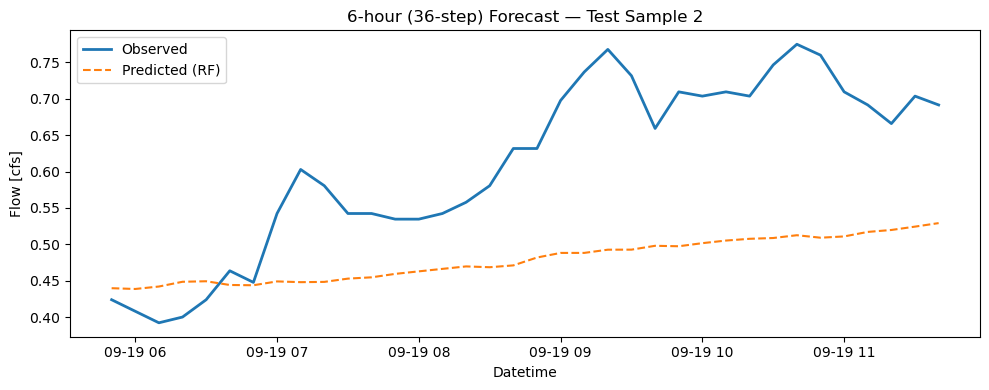

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have: flow_10min, values, X, y, y_test, y_test_pred
# and n_lags = 36, n_outputs = 36

idx = flow_10min.index.to_series().sort_values()
start_times = [idx.iloc[i] for i in range(n_lags, len(values) - n_outputs)]

# Align with your 70/15/15 split that produced X_train/X_val/X_test, y_train/y_val/y_test
train_size = int(0.7 * len(X))
val_size   = int(0.15 * len(X))
test_starts = start_times[train_size + val_size:]

# Pick a test window to visualize
k = 1  # change to see other test windows
future_index = pd.date_range(test_starts[k], periods=n_outputs, freq="10min")

pred_df = pd.DataFrame({
    "Observed":  y_test[k],
    "Predicted": y_test_pred[k]
}, index=future_index)

print(pred_df.head(12))  # preview first 2 hours

# --- Visualization ---
plt.figure(figsize=(10,4))
plt.plot(pred_df.index, pred_df["Observed"],  label="Observed",  linewidth=2)
plt.plot(pred_df.index, pred_df["Predicted"], label="Predicted (RF)", linestyle="--")
plt.title(f"6-hour (36-step) Forecast — Test Sample {k+1}")
plt.xlabel("Datetime")
plt.ylabel("Flow [cfs]")
plt.legend()
plt.tight_layout()
plt.show()


## Random Forest Regression [Attempt 2]  [selected model]

### Prepare features and sliding windows

In [22]:
import numpy as np
import pandas as pd

# Assumes flow_10min is your cleaned 10-min DataFrame with column "Flow[cfs]" and DatetimeIndex
df = flow_10min.copy()
df = df.sort_index()

# ---- Cyclic time features (daily & weekly) ----
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)

values = df["Flow[cfs]"].values
hour_sin = df["hour_sin"].values
hour_cos = df["hour_cos"].values
dow_sin  = df["dow_sin"].values
dow_cos  = df["dow_cos"].values
idx      = df.index.to_series().sort_values()

# ---- Window config ----
n_lags = 144      # 24 hours of past context
n_outputs = 18    # next 3 hours (10-min steps)

# ---- Build X (lags + time features) and y (multi-step targets) ----
X, y, start_times = [], [], []
for i in range(n_lags, len(values) - n_outputs):
    # past 24h (ends at i-1)
    window = values[i - n_lags:i]                       # shape (144,)
    # time features at the *current* forecast start time (idx[i])
    tf = [hour_sin[i], hour_cos[i], dow_sin[i], dow_cos[i]]  # shape (4,)
    X.append(np.hstack([window, tf]))                   # shape (148,)
    # next 18 values starting at idx[i] (i..i+17)
    y.append(values[i:i + n_outputs])                   # shape (18,)
    # timestamp for first predicted step
    start_times.append(idx.iloc[i])

X = np.array(X)           # (samples, 148)
y = np.array(y)           # (samples, 18)
start_times = np.array(start_times)
print(X.shape, y.shape)


(16816, 148) (16816, 18)


### Chronological 70/15/15 split

In [24]:
train_size = int(0.70 * len(X))
val_size   = int(0.15 * len(X))

X_train, X_val, X_test = (
    X[:train_size],
    X[train_size:train_size + val_size],
    X[train_size + val_size:]
)
y_train, y_val, y_test = (
    y[:train_size],
    y[train_size:train_size + val_size],
    y[train_size + val_size:]
)

test_starts = start_times[train_size + val_size:]
print(X_train.shape, X_val.shape, X_test.shape)


(11771, 148) (2522, 148) (2523, 148)


### Hyperparameter Tuning (RandomizedSearchCV + TimeSeriesSplit)

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, root_mean_squared_error

# ---- Define RMSE scorer for multi-output regression ----
rmse_scorer = make_scorer(
    root_mean_squared_error,
    greater_is_better=False,
    multioutput='uniform_average'
)

# ---- TimeSeriesSplit ensures chronological folds (no data leakage) ----
tscv = TimeSeriesSplit(n_splits=3)

# ---- Define parameter search space ----
param_distributions = {
    "n_estimators": [200, 300, 400, 600],
    "max_depth": [12, 16, 24, 32, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, 0.7],
    "bootstrap": [True]
}

# ---- Initialize base model ----
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# ---- Randomized search setup ----
search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=40,               # try 25 for quick runs
    scoring=rmse_scorer,
    cv=tscv,
    random_state=42,
    verbose=2,
    n_jobs=-1,
    refit=True               # retrain on full train set after tuning
)

# ---- Fit search on training data ----
search.fit(X_train, y_train)

print("Best parameters found:")
print(search.best_params_)
print(f"Best CV RMSE: {-search.best_score_:.4f}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters found:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 24, 'bootstrap': True}
Best CV RMSE: 0.0704


### Fitting the Best Model

In [28]:
# The best estimator is already refit automatically (refit=True)
rf_best = search.best_estimator_

# You can inspect or save it if needed
print(rf_best)

RandomForestRegressor(max_depth=24, max_features=0.5, min_samples_split=5,
                      n_estimators=600, n_jobs=-1, random_state=42)


In [36]:
import joblib

# This is the line you already have
rf_best = search.best_estimator_

# Add these lines to save the model
joblib.dump(rf_best, "rf_flow_model.joblib")
print("Successfully saved rf_flow_model.joblib")

Successfully saved rf_flow_model.joblib


### Evaluation on Validation and Test Sets

In [30]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# ---- Predictions ----
y_val_pred  = rf_best.predict(X_val)
y_test_pred = rf_best.predict(X_test)

# ---- Evaluation Function ----
def evaluate_multistep(y_true, y_pred):
    """
    Computes MAE and RMSE averaged across all 18 forecast horizons.
    """
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return mae, rmse

# ---- Evaluate ----
mae_val, rmse_val = evaluate_multistep(y_val, y_val_pred)
mae_test, rmse_test = evaluate_multistep(y_test, y_test_pred)

print(f"Validation → MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}")
print(f"Test       → MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}")


Validation → MAE: 0.0443, RMSE: 0.0554
Test       → MAE: 0.0449, RMSE: 0.0562


### Plot a single test forecast window (Observed vs Predicted

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumptions:
# - flow_10min is your DataFrame (DatetimeIndex, "Flow[cfs]")
# - n_lags = 144 (24h), n_outputs = 18 (3h)
# - X, y already built from sliding windows
# - y_test and y_test_pred exist (from your tuned rf_best)

values = flow_10min["Flow[cfs]"].values
idx = flow_10min.index.to_series().sort_values()

# Build start_times safely (timestamps for the first predicted step of each window)
start_times = [idx.iloc[i] for i in range(n_lags, len(values) - n_outputs)]
# start_times now has the same length as y (and X)

# Split indices consistent with your 70/15/15 split
train_size = int(0.70 * len(y))
val_size   = int(0.15 * len(y))
test_starts = start_times[train_size + val_size:]


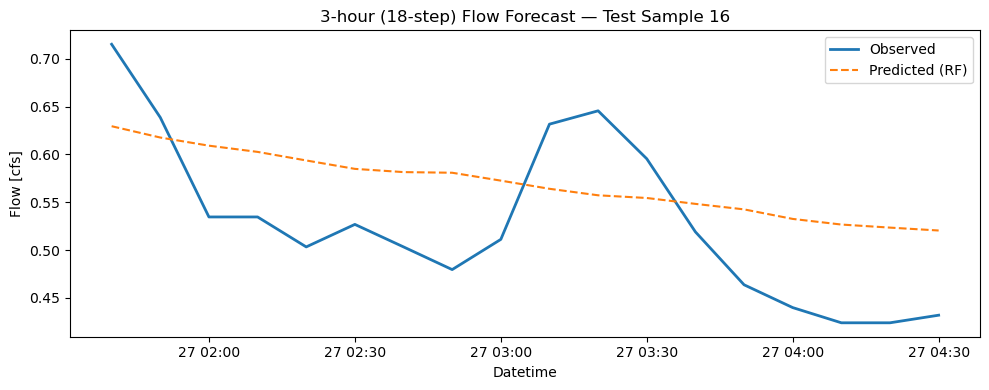

In [34]:
# Pick which test window to plot
sample_i = 15  # change to view another test forecast

future_index = pd.date_range(test_starts[sample_i], periods=n_outputs, freq="10min")
observed  = y_test[sample_i]
predicted = y_test_pred[sample_i]

plt.figure(figsize=(10,4))
plt.plot(future_index, observed,  label="Observed", linewidth=2)
plt.plot(future_index, predicted, label="Predicted (RF)", linestyle="--")
plt.title(f"3-hour (18-step) Flow Forecast — Test Sample {sample_i+1}")
plt.xlabel("Datetime"); plt.ylabel("Flow [cfs]")
plt.legend(); plt.tight_layout(); plt.show()


### (Optional) Horizon-wise Error Analysis

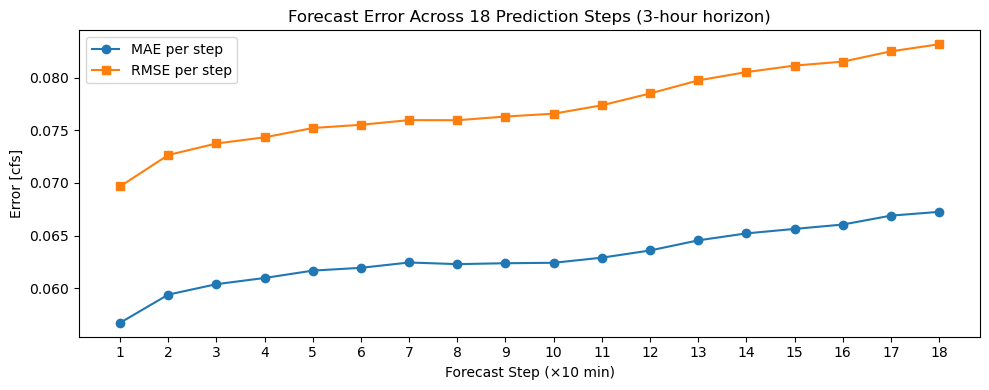

In [36]:
import matplotlib.pyplot as plt
import numpy as np

n_outputs = y_test.shape[1]

step_mae  = [mean_absolute_error(y_test[:, s], y_test_pred[:, s]) for s in range(n_outputs)]
step_rmse = [root_mean_squared_error(y_test[:, s], y_test_pred[:, s]) for s in range(n_outputs)]

plt.figure(figsize=(10,4))
plt.plot(np.arange(1, n_outputs+1), step_mae,  marker='o', label="MAE per step")
plt.plot(np.arange(1, n_outputs+1), step_rmse, marker='s', label="RMSE per step")
plt.xticks(range(1, n_outputs+1))
plt.xlabel("Forecast Step (×10 min)")
plt.ylabel("Error [cfs]")
plt.title("Forecast Error Across 18 Prediction Steps (3-hour horizon)")
plt.legend()
plt.tight_layout()
plt.show()


### Config

In [140]:
import numpy as np
import pandas as pd

# Base series (DatetimeIndex, 10-min)
df = flow_10min.copy().sort_index()

# Horizon: 1 hour ahead at 10-min resolution
n_outputs = 6

# Context: lags from the last 24–48 hours (10-min data)
n_lags = 144            # 24h of lags
use_two_day_context = True
seasonal_lag_1d = 144   # 1 day
seasonal_lag_2d = 288   # 2 days



### Feature engineering (time & seasonal)

In [142]:
# Cyclic time-of-day & day-of-week
df["hour"] = df.index.hour
df["dow"]  = df.index.dayofweek
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)

# Seasonal anchors: value exactly 1 day and 2 days ago
df["flow_lag_1d"] = df["Flow[cfs]"].shift(seasonal_lag_1d)
df["flow_lag_2d"] = df["Flow[cfs]"].shift(seasonal_lag_2d)

# Smoothing features (use past-only windows)
df["roll_mean_1h"] = df["Flow[cfs]"].rolling(6, min_periods=1).mean()
df["roll_mean_3h"] = df["Flow[cfs]"].rolling(18, min_periods=1).mean()


### Build sliding windows (multi-output = 6 steps)

In [144]:
values = df["Flow[cfs]"].values
hour_sin = df["hour_sin"].values
hour_cos = df["hour_cos"].values
dow_sin  = df["dow_sin"].values
dow_cos  = df["dow_cos"].values
lag1d    = df["flow_lag_1d"].values
lag2d    = df["flow_lag_2d"].values
rm1h     = df["roll_mean_1h"].values
rm3h     = df["roll_mean_3h"].values
idx      = df.index

# Ensure we start far enough to have all features
min_start = max(n_lags, seasonal_lag_1d, (seasonal_lag_2d if use_two_day_context else 0))

X, y, start_times = [], [], []
for i in range(min_start, len(values) - n_outputs):
    # past 24h lags
    window = values[i - n_lags:i]  # (144,)

    # time features & seasonal anchors at forecast start (time i)
    feats = [
        hour_sin[i], hour_cos[i], dow_sin[i], dow_cos[i],
        lag1d[i],
        (lag2d[i] if use_two_day_context else np.nan),
        rm1h[i], rm3h[i]
    ]
    X.append(np.hstack([window, feats]))              # 144 + 8 = 152 features (or 151 if no 2d)
    y.append(values[i:i + n_outputs])                 # next 6 values (1h)
    start_times.append(idx[i])

X = np.array(X)
y = np.array(y)
start_times = np.array(start_times)

print("Shapes -> X:", X.shape, " y:", y.shape)


Shapes -> X: (10330, 152)  y: (10330, 6)


### Chronological split (70/15/15)

In [146]:
train_size = int(0.70 * len(X))
val_size   = int(0.15 * len(X))

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]
test_starts = start_times[train_size + val_size:]

print(X_train.shape, X_val.shape, X_test.shape)


(7230, 152) (1549, 152) (1551, 152)


### Tune RF (time-aware CV) and fit

In [148]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error

# RMSE scorer (multi-output averaged)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False, multioutput='uniform_average')
tscv = TimeSeriesSplit(n_splits=3)

param_distributions = {
    "n_estimators": [200, 300, 400, 600],
    "max_depth": [12, 16, 24, 32, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, 0.7],
    "bootstrap": [True]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=rmse_scorer,
    cv=tscv,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    refit=True
)

search.fit(X_train, y_train)
rf_best = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'max_depth': None, 'bootstrap': True}
Best CV RMSE: 0.0586898519617696


### Evaluate

In [150]:
y_val_pred  = rf_best.predict(X_val)
y_test_pred = rf_best.predict(X_test)

def eval_multi(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return mae, rmse

mae_val, rmse_val = eval_multi(y_val, y_val_pred)
mae_test, rmse_test = eval_multi(y_test, y_test_pred)

print(f"Validation → MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}")
print(f"Test       → MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}")


Validation → MAE: 0.0406, RMSE: 0.0512
Test       → MAE: 0.0562, RMSE: 0.0682


### Plot observed vs predicted (1 test window)

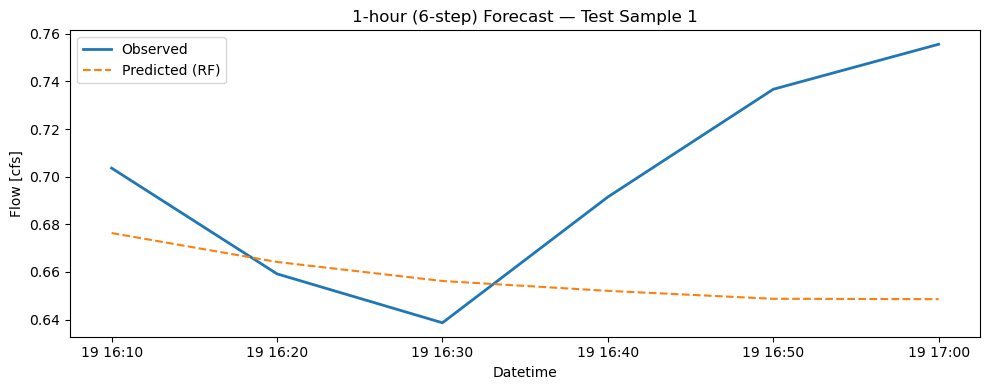

In [154]:
import matplotlib.pyplot as plt

k = 0  # pick a test forecast window
future_index = pd.date_range(test_starts[k], periods=n_outputs, freq="10min")

plt.figure(figsize=(10,4))
plt.plot(future_index, y_test[k],      label="Observed", linewidth=2)
plt.plot(future_index, y_test_pred[k], label="Predicted (RF)", linestyle="--")
plt.title(f"1-hour (6-step) Forecast — Test Sample {k+1}")
plt.xlabel("Datetime"); plt.ylabel("Flow [cfs]")
plt.legend(); plt.tight_layout(); plt.show()
